In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
from glob import glob
import subprocess
import shutil
import traceback
import random
import pickle

import joblib
from concurrent.futures import ProcessPoolExecutor

from backports import tempfile

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import psrchive

import pipe

In [68]:
wsrt_raw_location = "/nimrod1/aarchiba/0337+17/WSRT-raw"
wsrt_obs_glob = wsrt_raw_location+"/*/*0337*/"

td = "/tmp/wsrt_problem"

class DiscontinuityError(ValueError):
    pass

def max_smearing(F,G):
    P = F.get_Integration(0).get_folding_period()
    deltas = []
    for i in range(len(F)):
        d = (G.get_Integration(i).get_epoch()-F.get_Integration(i).get_epoch()).in_days()*86400
        deltas.append(d/P)
    deltas = np.array(deltas)

    smear = np.diff(deltas)
    smear = (smear+0.5) % 1 - 0.5
    
    return np.amax(smear)


def process_wsrt_day(d):
    success_file = d+"/success"
    failure_file = d+"/failure.pickle"
    if os.path.exists(td):
        shutil.rmtree(td)
    os.mkdir(td)
    try:
        extra_info = dict(day=d, max_smearing=0)
        for s in glob(d+"/Band*"):
            b = s.split("/")[-1]
            tadd = td+"/"+b+".tadd.ar"
            pipe.check_call(["psradd", "-o", tadd]+glob(s+"/u*.ar"))
            F = psrchive.Archive_load(tadd)

            mjd = (F.get_Integration(0).get_start_time().in_days()
                +F.get_Integration(len(F)-1).get_end_time().in_days())/2
            par = par_db.get_par_for(mjd)
            pipe.check_call(["pam", "-E", par, "-e", "align.ar", tadd])
            align = td+"/"+b+".tadd.align.ar"
            G = psrchive.Archive_load(align)

            s = max_smearing(F,G)
            extra_info["max_smearing"] = max(extra_info["max_smearing"], s)
            extra_info["mjd"] = mjd
            extra_info["par"] = par

            del F
            del G
        pipe.check_call(["psradd", "-o", td+"/raw.ar", "-R"]+glob(td+"/Band*.tadd.align.ar"))
        shutil.copy(td+"/raw.ar", "raw.ar")
        F = psrchive.Archive_load(td+"/raw.ar")
        l = (F.end_time()-F.start_time()).in_seconds()
        M = "%.1f" % (((F.end_time()+F.start_time())).in_days()/2)
        #T = F.get_nsubint()*F.get_first_Integration().get_duration()
        T = F.integration_length()
        extra_info["length"] = T
        extra_info["centre_frequency"] = F.get_centre_frequency()
        extra_info["P"] = F.get_Integration(0).get_folding_period()
        extra_info["file"] = M
        del F
        if np.abs(l-T)> 5:
            raise DiscontinuityError("Observation in directory %s appears not to be contiguous: "
                             "total integration time %f but start-to-end time %f"
                             % (d,T,l))
        shutil.copy(td+"/raw.ar", wsrt_data+"wsrt_%s.raw.ar" % M)
        with open(success_file,"wb") as f:
            pickle.dump(extra_info, f)
        return extra_info
    except Exception as e:
        with open(failure_file, "wb") as f:
            pickle.dump(e,f)
        raise


In [69]:
d = "/nimrod1/aarchiba/0337+17/WSRT-raw/11Apr2012/J0337+1715-1380/"

process_wsrt_day(d)

CalledProcessError: CalledProcessError(
            cmd=['psradd', '-o', '/tmp/wsrt_problem/raw.ar', '-R', '/tmp/wsrt_problem/Band6.tadd.align.ar', '/tmp/wsrt_problem/Band0.tadd.align.ar', '/tmp/wsrt_problem/Band2.tadd.align.ar', '/tmp/wsrt_problem/Band5.tadd.align.ar', '/tmp/wsrt_problem/Band3.tadd.align.ar', '/tmp/wsrt_problem/Band1.tadd.align.ar', '/tmp/wsrt_problem/Band7.tadd.align.ar', '/tmp/wsrt_problem/Band4.tadd.align.ar'],
            returncode=255,
            output='''''',
            error='''psradd: shell not available; insufficient resources
''')

##### pipe.__file__

In [34]:
par_db = pipe.EphemerisCollection(directory="/nimrod1/aarchiba/0337+17/ephemerides/")

In [37]:
inf = "/tmp/wsrt_problem/Band4.tadd.ar"
outf = "/tmp/wsrt_problem/Band4.tadd.align"
F = psrchive.Archive_load(inf)
mjd = (F.get_Integration(0).get_start_time().in_days()
    +F.get_Integration(len(F)-1).get_end_time().in_days())/2
par = par_db.get_par_for(mjd)
pipe.check_call(["pam", "-E", par, "-e", "align", inf])
G = psrchive.Archive_load(outf)

In [38]:
I = F.get_Integration(0)
J = G.get_Integration(0)

In [46]:
print (J.get_epoch()-I.get_epoch()).in_days()*86400

0.00237752092653


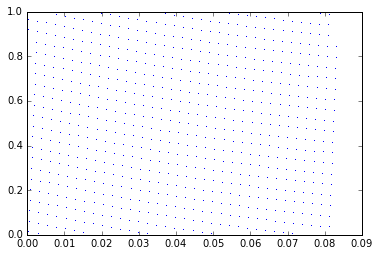

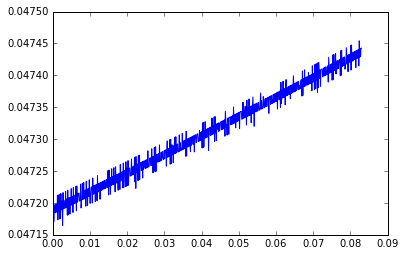

In [62]:
P = I.get_folding_period()
deltas = []
ts = []
mjd0 = None 
for i in range(len(F)):
    if mjd0 is None:
        mjd0 = F.get_Integration(i).get_epoch().in_days()
    t = F.get_Integration(i).get_epoch().in_days() - mjd0
    d = (G.get_Integration(i).get_epoch()-F.get_Integration(i).get_epoch()).in_days()*86400
    deltas.append(d/P)
    ts.append(t)
deltas = np.array(deltas)
ts = np.array(ts)

plt.plot(ts, deltas, ",")
plt.figure()

smear = np.diff(deltas)
smear = (smear+0.5) % 1 - 0.5
plt.plot(ts[:-1], smear)
#plt.ylim(-1,1)


In [52]:
E = F.get_ephemeris()

In [57]:
P = I.get_folding_period()

In [63]:
F.get_centre_frequency()

1390.0

In [ ]:
F.